In [4]:
%matplotlib inline
import sys, os
os.environ['THEANO_FLAGS'] = 'device=gpu'
sys.path.append(os.getcwd()+"/..")
from tools.system.imgtovideo import imgs_to_video
from data import load_data
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
from lasagne import layers as L
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import pandas as pd

from tqdm import tqdm
import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

from IPython.display import HTML, Image


from tools.brushstroke.common import (
    resize_set, load_model, get_bias, 
    get_scale, build_brush_func,
    build_encode_func,
    build_image_to_code_func,
    build_code_to_image,
    to_grid_of_images,
    seq_to_video,
    embed_video,
    disp_grid,
    prop_uniques,
    hash_array,
    normalize,
    sigmoid,
    build_pointer_images)

from functools import partial
from tools.common import find_training_job
def accumulate(X, fn):
    for t in range(1, X.shape[1]):
        X[:, t] = fn(X[:, t], X[:, t - 1])
    return X

def mask_op(new, prev, eps=0.1):
    img1 = prev
    img2 = new
    a2 = 1 - (np.abs(img2[:,0])<eps) * (np.abs(img2[:,1])<eps) * (np.abs(img2[:,2])<eps)   
    a2=a2[:,None, :, :]
    img = img1 * (1 - a2) + img2 * a2
    return img

def smooth_mask_op(new, prev):
    img1 = prev
    img2 = new
    a2 = new.mean(axis=1, keepdims=True)
    img = img1 * (1 - a2) + img2 * a2
    return img

def softmax(x):
    x = np.exp(x)
    return x / x.sum(axis=1, keepdims=True)

def sparse_softmax(x):
    m = np.max(x, axis=1, keepdims=True)
    return softmax(x) * (x==m)

def softmax_t(x):
    return softmax(x*100)

from utils.sparsemax_theano import sparsemax as sparsemax_theano
m = T.matrix()
sparsemax = theano.function([m], sparsemax_theano(m))

In [80]:
find_training_job('1f9e188961528a1c5158c20e536c3a04')['summary']

u'9a52b774e57e3cf532e3212ad47abaf9'

## Load model and build functions

In [81]:
model, data, layers = load_model("../jobs/results/9a52b774e57e3cf532e3212ad47abaf9/model.pkl", 
                                 data_params={'nb_examples': 200, 'image_collection_mode': 'random'})
w, h = layers['output'].output_shape[2:]
print(json.dumps(model.hypers['model_params'], indent=2))

Loading data...


INFO:tasks:Loading data...


[0 9 3 ..., 0 3 6]
Loading the model...


INFO:tasks:Loading the model...


Compiling the model...


INFO:tasks:Compiling the model...
INFO (theano.gof.compilelock): Waiting for existing lock by process '25425' (I am process '21988')
INFO:theano.gof.compilelock:Waiting for existing lock by process '25425' (I am process '21988')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/mcherti/.theano/compiledir_Linux-2.6-bl6.Bull.75.x86_64-x86_64-with-redhat-6.3-V1-x86_64-2.7.12-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /home/mcherti/.theano/compiledir_Linux-2.6-bl6.Bull.75.x86_64-x86_64-with-redhat-6.3-V1-x86_64-2.7.12-64/lock_dir


{
  "nb_recurrent_layers": 2, 
  "color": "predicted", 
  "n_steps": 79, 
  "normalize_func": "sigmoid", 
  "nb_recurrent_units": [
    500, 
    100
  ], 
  "y_stride": 1, 
  "reduce_func": "sum", 
  "nonlin_out": "sigmoid", 
  "parallel_reduce_func": "sum", 
  "patch_size": 4, 
  "y_sigma": 0.5, 
  "nonlin": "rectify", 
  "y_min": 0, 
  "nb_fc_units": [
    600
  ], 
  "x_max": "width", 
  "patch_index": 0, 
  "parallel": 1, 
  "x_stride": 1, 
  "nb_fc_layers": 1, 
  "parallel_share": false, 
  "y_max": "height", 
  "eps": 0, 
  "recurrent_model": "lstm", 
  "x_min": 0, 
  "x_sigma": 0.5
}


In [82]:
nb_parallel = model.hypers['model_params'].get('parallel', 1)
coord_layers = [l for l in layers.keys() if 'coord' in l]
brush_layers = [l for l in layers.keys() if 'brush' in l]
coord = coord_layers[0]
brush = brush_layers[0]
X = T.tensor4()
C = T.tensor3()    
get_brushes = theano.function(
    [X], 
    L.get_output(layers[brush], X))
encoders = []
for c in coord_layers:
    encoder = build_encode_func(layers, lay=c)
    encoders.append(encoder)
get_reprs = []
for c in coord_layers:
    get_reprs.append(theano.function([X], L.get_output(layers[c], X)))
get_repr = theano.function([X], L.get_output(layers[coord], X))
get_brush = build_brush_func(
    layers, 
    lay=brush_layers,
    nonlin=lambda x:x) # transforms an image to sequence of imagess
reconstruct = model.reconstruct # reconstructs an image

if 'scaled_output' in layers:
    scale = get_scale(layers)
else:
    scale = np.array([1])
if 'biased_output' in layers:
    bias = get_bias(layers)
else:
    bias = np.array([0])

In [31]:
get_brush = build_brush_func(
    layers, 
    lay=brush_layers,
    nonlin=lambda x:x)

In [32]:
img2code = build_image_to_code_func(layers, lay=tuple(coord_layers))
tensors = tuple([T.tensor3() for _ in range(len(coord_layers))])
code2img = build_code_to_image(layers, X=tensors, lay=tuple(coord_layers))

In [33]:
if 'biased_resid_output' in layers:
    X = T.tensor4()
    get_resid = theano.function([X], L.get_output(layers['biased_resid_output'], X))
    get_out = theano.function([X], L.get_output(layers['biased_output'], X))
    get_raw_out = theano.function([X], L.get_output(layers['raw_output'], X))
    get_out_from_raw_out = theano.function([X], L.get_output(layers['output'], {layers['raw_output']:X}))

In [34]:
data.load()
X = model.preprocess(data.X[0:10*10])

In [35]:
np.set_printoptions(formatter={'float': lambda x:'{:.4f}'.format(x)})

(30, 30, 8, 3)


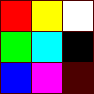

In [36]:
real_colors = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1 ,0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 0, 0]
]
real_colors = np.array(real_colors, dtype='float32')

img = real_colors[np.newaxis, np.newaxis, :, :] * np.ones((30, 30, 1, 3))
print(img.shape)
img = img.transpose((2, 3, 0, 1))
img = disp_grid(img, normalize=False, border=1, bordercolor=(0.3,0,0))
imsave('imgs/colors.png', img)
Image('imgs/colors.png', width=400, height=400)

In [37]:
n_steps = model.hypers['model_params']['n_steps']
code = np.zeros((len(layers['brush'].colors_.get_value()), n_steps, layers['coord'].output_shape[2]  ))
code = code.astype(np.float32)
code[:, :, 0] = 0
code[:, :, 1] = 0
code[:, :, 3] = 1000
code[:, :, 5] = 1000
C = np.arange(len(code))
code[C, :, C+6] = 100
img = code2img(code)
img = disp_grid(img, normalize=False, border=1, bordercolor=(0.3,0,0))
img = np.clip(img, 0, 1)
imsave('imgs/colors.png', img)
Image('imgs/colors.png', width=200, height=200)

KeyError: 'brush'

In [85]:
img = (  (layers['brush'].colors_.get_value()) * scale.flatten() + bias.flatten())
print(img.min(), img.max())
img = np.clip(img, 0, 1)
img = img[:, :, None, None] * np.ones((1, 3, 30, 30))
img = disp_grid(img, normalize=False, border=1, bordercolor=(0.3, 0, 0))
imsave('imgs/colors.png', img)
Image('imgs/colors.png', width=400, height=400)

KeyError: 'brush'

## Analyze

In [38]:
layers['brush'].assign_

KeyError: 'brush'

In [39]:
codes = img2code(X)
r = codes[0]

In [40]:
r1 = softmax(r[:, 0, 6:14])
r1/=r1.max(axis=1, keepdims=True)
r2 = softmax(r[:, 1, 6:14])
r2/=r2.max(axis=1, keepdims=True)
zero = np.zeros((r1.shape[0], 10))
s = np.hstack((r1, zero, r2))
fig = plt.figure(figsize=(20, 20))
plt.imshow(s, cmap='viridis', interpolation='none')

ValueError: zero-size array to reduction operation maximum which has no identity

In [41]:
codes = img2code(X)
r = codes[0]
pr = sparse_softmax(r[:, 0, 6:14])
c = np.dot(pr, (layers['brush'].colors_.get_value())  )
c = c * scale.flatten() + bias.flatten()
c = c[:, :, np.newaxis, np.newaxis] * np.ones((1, 1, 16, 16))
c = np.clip(c, 0, 1)
imsave('imgs/b.png', 
       disp_grid(c, border=1, bordercolor=(0.3,0,0), normalize=False)
)
Image('imgs/b.png', width=400, height=400)

ValueError: zero-size array to reduction operation maximum which has no identity

In [83]:
from matplotlib.colors import Normalize, NoNorm
b, = get_brush(X)
b = (b* scale + bias)
b = np.clip(b, 0, 1)
fig = plt.figure(figsize=(10, 10))
imsave('imgs/b.png', 
       disp_grid(b[:, 1], border=1, bordercolor=(0.3,0,0), normalize=False)
)
Image('imgs/b.png', width=400, height=400)

TypeError: ('Bad input argument to theano function with name "/home/mcherti/work/code/feature_generation/ipynb/../tools/brushstroke/common.py:113" at index 0 (0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

In [84]:
codes = img2code(X)
r = codes[0]
img = code2img(*codes)
img = np.clip(img, 0, 1)
img = disp_grid(img, border=1, bordercolor=(0.3,0.3,0.3), normalize=False)
imsave('imgs/im.png', img)
Image('imgs/im.png', width=400, height=400)

TypeError: ('Bad input argument to theano function with name "/home/mcherti/work/code/feature_generation/ipynb/../tools/brushstroke/common.py:135" at index 0 (0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

## Construct a sequence with the enhancement module

In [44]:
def construct_seq(X):
    seq = []
    feat = img2code(X)
    for t in range(layers[coord_layers[0]].output_shape[1]):
        feat_ = [f.copy() for f in feat]
        for f in feat_:
            f[:,t+1:]=-100
        img = code2img(*feat_)
        seq.append(img)
    return seq

seq = construct_seq(X)
seq = np.array(seq)

In [86]:
seq_ = np.array(seq[:])
seq_ = seq.transpose((1, 0, 2, 3, 4))
seq_to_video(seq_, 'vids/refined_seq.mp4')
embed_video('vids/refined_seq.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_video_Ho5cf/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/vids/refined_seq.mp4


## get coords from images

In [87]:
codes = []
for encoder in get_reprs:
    code = encoder(X)
    codes.append(code)
cols = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1)]
cols = cols + cols
print(model.hypers['model_params']['patch_size'])
pointers = []
for i, code in enumerate(codes):
    if 'x_stride' in layers['brush_0'].assign_:
        print(code.shape)
        sx = sigmoid(code[:,:, layers['brush_0'].assign_['x_stride']]) * model.hypers['model_params']['patch_size']
    else:
        sx = None    

    if 'y_stride' in layers['brush_0'].assign_:
        sy = sigmoid(code[:,:, layers['brush_0'].assign_['y_stride']]) * model.hypers['model_params']['patch_size']
    else:
        sy = None
    pointer = build_pointer_images(code[:, :, 0:2], cols[i], w, h, sx=sx, sy=sy, p=1)
    pointers.append(pointer)
pointers = sum(pointers)
seq_to_video(pointers, 'vids/pointers.mp4')
embed_video('vids/pointers.mp4')

TypeError: ('Bad input argument to theano function with name "<ipython-input-82-23f3318a2cf0>:17" at index 0 (0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

## video of gen

In [88]:
imgs = get_brush(X) # (examples, time, c, w, h)
imgs = sum(imgs)
imgs = imgs * scale + bias
imgs = imgs
imgs = np.clip(imgs, 0, 1)
seq_to_video(imgs, 'vids/seq.mp4', border=2, bordercolor=(0.3,0,0),framerate=5, rate=5, normalize=False)
embed_video('vids/seq.mp4')

TypeError: ('Bad input argument to theano function with name "/home/mcherti/work/code/feature_generation/ipynb/../tools/brushstroke/common.py:113" at index 0 (0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

NameError: name 'get_resid' is not defined

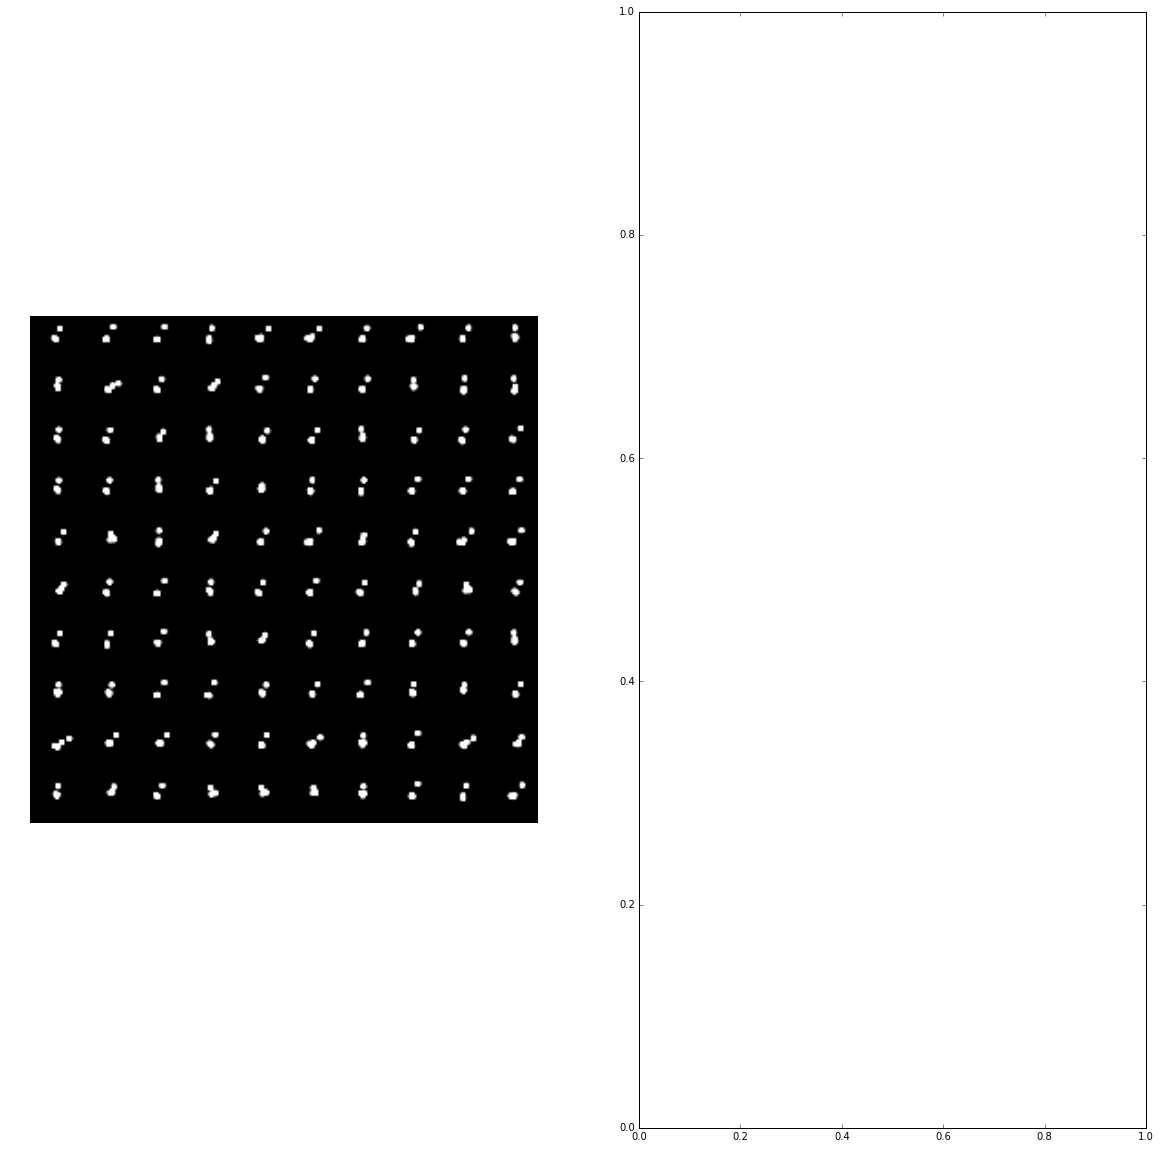

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
d = imgs[:,-1].copy()
d = disp_grid(d)
ax1.set_axis_off()
ax1.imshow(d)
m = get_resid(X)
d = ( ((get_resid(X)+get_out(X)))*0.5     )
#d = 1-sigmoid(d)
d = normalize(d, axis=0)
d = disp_grid(d)
ax2.set_axis_off()
ax2.imshow(d)

## Reconstruct

In [90]:
im1 = disp_grid(model.preprocess(data.X[0:100]), border=1, bordercolor=(.3, .3, .3))
r  = model.reconstruct(model.preprocess(data.X[0:100]))
r = np.clip(r, 0, 1)
im2 = disp_grid(r, border=1, bordercolor=(.5, 0, 0), normalize=False)
im_mix = np.empty(( max(im1.shape[0], im2.shape[0]), im1.shape[1] + im2.shape[1], 3))
im_mix[0:im1.shape[0], 0:im1.shape[1]] = im1
im_mix[0:im2.shape[0], im1.shape[1]:] = im2
imsave('imgs/im_mix.png', im_mix)
Image('imgs/im_mix.png', width=800, height=800)

AttributeError: 'SubSampled' object has no attribute 'X'

## Sharpen

In [ ]:
from skimage.io import imread
from skimage.draw import circle
texture = imread('imgs/metal_rust_texture_05_by_fantasystock.jpg')/255.
plt.imshow(texture)
S = 4
x = 200
patches = np.zeros((1, 3, 7*S, 7*S))
ph, pw = patches.shape[2:]
rr, cc = circle(ph/2, pw/2, S*3)    
#patches[:, :, rr, cc] = 1
#plt.imshow(patches[0,0], cmap='gray')

In [ ]:
from skimage.draw import circle

r = get_repr(X)


def sharpen_draw_single(gx, gy, patch, col, w_out, h_out, img=None, mask=None):
    c = patch.shape[0]
    ph = patch.shape[1]
    pw = patch.shape[2]
    if img is  None:
        img = np.zeros((c, w_out, h_out))
        mask = np.zeros((c, w_out, h_out))
    shape = img[:, gy:gy+ph, gx:gx+pw].shape
    
    n = patch[:, :shape[1], :shape[2]] * col[:, None, None]
    mask_n = (1 - (n[0]==0) * (n[1]==0) * (n[2]==0))
    o =   img[:, gy:gy+ph, gx:gx+pw]
    mask_o = (1 - (o[0]==0) * (o[1]==0) * (o[2]==0))
    img[:, gy:gy+ph, gx:gx+pw] = n * mask_n + o * (1 - mask_n) 
    img[:, gy:gy+ph, gx:gx+pw] = o * 0.5 + n
    return img

def sharpen_draw(r, S=8):
    br = 'brush'
    
    if 'patch_index' in layers[br].assign_:
        patch_indices = layers[br].assign_['patch_index']
    else:
        patch_indices = None
    if 'color' in layers[br].assign_:
        color_indices = layers[br].assign_['color']
    else:
        color_indices = None
    patches = layers[br].patches_.get_value()
    patches = np.ones((1, 3, S*2, S*2))
    ph, pw = patches.shape[2:]    
    ph, pw = patches.shape[2:]
    rr, cc = circle(ph/2, pw/2, S*1)
    #patches[:, :, rr, cc] = 1
    #patches[:] *= texture.transpose((2, 0, 1))[:, 100:100+ph, 100:100+pw]
    w_out = w * S
    h_out = h * S
    c = patches.shape[1]
    imgs = np.zeros((r.shape[0], c, h_out, w_out))
    masks = np.zeros_like(imgs)

    for t in range(r.shape[1]):
        rt = r[:, t]
        if patch_indices:
            patch_index = rt[:, slice(*patch_indices)].argmax(axis=1)
        else:
            patch_index = np.zeros((rt.shape[0],))
        if color_indices:
            color = (rt[:, slice(*color_indices)])
            color = sigmoid(color)
        else:
            color = np.ones((rt.shape[0], layers['output'].output_shape[1]))
        for i in range(imgs.shape[0]):
            gx = int(sigmoid(rt[i, 0]) * w_out)
            gy = int(sigmoid(rt[i, 1]) * h_out)
            sharpen_draw_single(gx, gy, patches[patch_index[i]], color[i], w_out, h_out, img=imgs[i], mask=masks[i])
    return imgs
fig = plt.figure(figsize=(10, 10))
imgs = sharpen_draw(r, S=4)
imgs = imgs * scale[0] + bias[0]
imgs = sigmoid(imgs)
imgs = np.clip(imgs, 0, 1)
img = disp_grid(imgs)
imsave('imgs/sharpen.png', img)
Image('imgs/sharpen.png')

## iterative refinement

In [91]:
#np.random.seed(22)
nb_iter = 100
nb_examples = 100
thresh = 0.5
use_noise = False
learning_rate = 1
c = layers['output'].output_shape[1]
# PREP
if thresh == 'moving':
    whitepx_ratio = 0.13
    #whitepx_ratio = (data.X>0.5).sum() / np.ones_like(data.X).sum()

imgs = np.empty((nb_examples, nb_iter + 1, c, w, h)) # 1 = color channel
imgs = imgs.astype(np.float32)
imgs[:, 0] = np.random.uniform(size=(nb_examples, c, w, h))

if use_noise: noise = np.random.normal(0, 0.001, size=imgs[:, 0].shape).astype(np.float32) #(for colored images)
else: noise = 0

scores = []
diversities = []

# ITERATIOn

for i in tqdm(range(1, nb_iter + 1)):
    
    if use_noise:noise = np.random.normal(0, 1, size=imgs[:, 0].shape).astype(np.float32) #(for colored images)
    else:noise = 0
    
    new = model.reconstruct(imgs[:, i - 1] + noise)
    prev = imgs[:, i - 1] 
    imgs[:, i] = new * learning_rate + prev * (1-learning_rate)
    if c == 1:
        if thresh == 'moving':
            vals = imgs[:, i].flatten()
            vals = vals[np.argsort(vals)]
            thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
        else:
            thresh_ = thresh
        if thresh_:
            imgs[:, i] = imgs[:, i] > thresh_ # binarize
    score = np.abs(imgs[:, i - 1] - imgs[:, i]).sum()
    scores.append(score)
    diversity = prop_uniques(imgs[:, i])
    diversities.append(diversity)

In [92]:
imgs = get_brush(imgs[:, 0]) # (examples, time, c, w, h)
imgs = sum(imgs)
imgs = imgs * scale + bias
imgs = imgs
imgs = np.clip(imgs, 0, 1)
seq_to_video(imgs, 'vids/seq.mp4', border=2, bordercolor=(0.3,0,0),framerate=10, rate=10, normalize=False)
embed_video('vids/seq.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_video_phBYj/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 10 -i img%08d.png -c:v libx264 -r 10 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/vids/seq.mp4


## Check nearest neighbors in dataset of the generated images

In [74]:
print(layers)
hid = 'input'
x_t = T.tensor4()
get_hid = theano.function([x_t], L.get_output(layers[hid], x_t))

OrderedDict([('input', <lasagne.layers.input.InputLayer object at 0x7fe726c545d0>), ('fc1_net0', <lasagne.layers.dense.DenseLayer object at 0x7fe7291b2890>), ('fc2_net0', <lasagne.layers.dense.DenseLayer object at 0x7fe72478b810>), ('fc3_net0', <lasagne.layers.dense.DenseLayer object at 0x7fe723e61ed0>), ('recurrent0_0', <lasagne.layers.recurrent.RecurrentLayer object at 0x7fe72274cf90>), ('coord_0', <layers.TensorDenseLayer object at 0x7fe71fcc1f10>), ('brush_0', <helpers.GenericBrushLayer object at 0x7fe724740d10>), ('raw_output', <helpers.ExpressionLayerMulti object at 0x7fe721a8ae50>), ('scaled_output', <lasagne.layers.special.ScaleLayer object at 0x7fe724d55150>), ('biased_output', <lasagne.layers.special.BiasLayer object at 0x7fe7243e1210>), ('output', <lasagne.layers.special.NonlinearityLayer object at 0x7fe7297d9d90>)])


(20, 20)


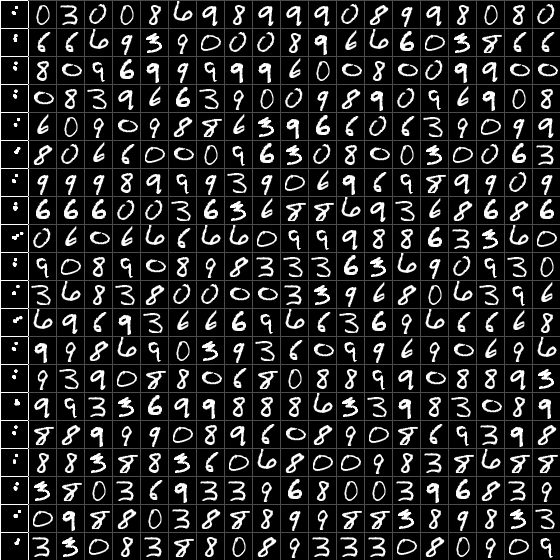

In [75]:
nb_neighb = 20
#c=3
generated = imgs[0:20, -1].copy()
generated = np.clip(generated, 0, 1)
dataset = model.preprocess(data.X)
def euc(x, y):
    x = get_hid(x)
    y = get_hid(y)
    x = x.reshape((x.shape[0], -1))
    y = y.reshape((y.shape[0], -1))
    x = x[None, :, :]
    y = y[:, None, :]
    axes = np.arange(2, len(x.shape))
    return ((x-y)**2).mean(axis=axes)

dist = euc

neighb = (dist(generated, dataset)).argsort(axis=1)
neighb = neighb[0:nb_neighb, :]
print(neighb.shape)
shape = neighb.shape
neighb = neighb.flatten()
neighb = dataset[neighb]
neighb = neighb.reshape((shape[0], shape[1], c, h, w))
neighb = np.concatenate((generated[None,:], neighb), axis=0)
img = np.empty(( shape[0]*h, shape[1] *w, c))
for y in range(shape[0]):
    for x in range(shape[1]):
        img[y*h:y*h+h, x*w:x*w+w] = neighb[x,y].transpose((1, 2, 0))
        #borders
        img[y*h:y*h+h, x*w:x*w+1]=0.3 if x>1 else 1
        img[y*h:y*h+1, x*w:x*w+w+1]=0.3 if x>0 else 1
imsave('imgs/neigh.png', img[:,:,0] if c==1 else img)
Image('imgs/neigh.png')

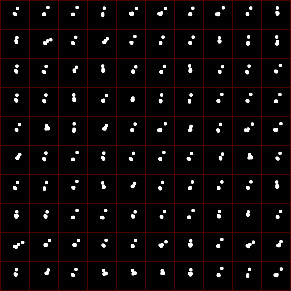

In [76]:
fig = plt.figure(figsize=(10, 10))
im = imgs[:, -1]
im = np.clip(im, 0, 1)


p = 0#padding
im_pad = np.zeros((im.shape[0], im.shape[1], im.shape[2]+2*p, im.shape[3]+2*p))
for i in range(im.shape[0]):
    for j in range(c):
        im_pad[i, j] = np.pad(im[i, j], (p, p), 'constant', constant_values=1)
im = im_pad
img = disp_grid(im, border=1, bordercolor=(0.3, 0, 0), normalize=False)
imsave('imgs/ir.png', img)
Image('imgs/ir.png', width=500, height=500)

In [57]:
seq_to_video(np.clip(imgs, 0, 1), 'vids/ir.mp4', border=2, bordercolor=(0.3, 0, 0), normalize=False)
embed_video('vids/ir.mp4')

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: /tmp/img_to_video6RRPgz/img00000000.png is a low contrast image
  warn('%s is a low contrast image' % fname)


ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/vids/ir.mp4


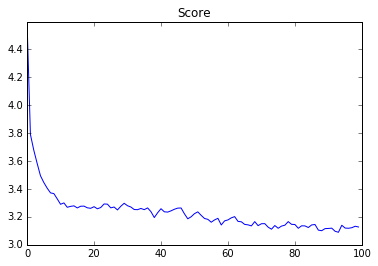

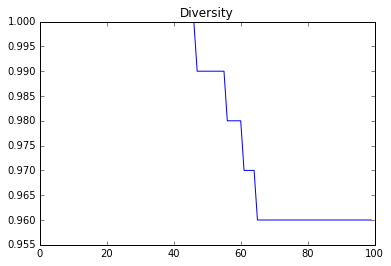

In [58]:
plt.title('Score')
plt.plot(np.log(np.array(scores)) / np.log(10))
plt.show()
plt.title('Diversity')
plt.plot(diversities)
plt.show()

## Feeding a new image

In [59]:
kw = {
"pipeline": [
    {"name": "imagefilelist", "params": {"pattern": "{chairs}"}},
    {"name": "shuffle", "params": {}},
    {"name": "imageread", "params": {}},
    {"name": "normalize_shape", "params": {}},
    {"name": "force_rgb", "params": {}},
    {"name": "crop", "params": {"shape": (128, 128), "pos": "center", "mode": "constant"}},   
    {"name": "resize", "params": {"shape": [h, w]}},
    {"name": "divide_by", "params": {"value": 255}},
    {"name": "order", "params": {"order": "th"}}
]
}
dt_test = load_data('loader', w=w, h=h, **kw)

In [60]:
# load from file
c=3
nb = 100
dt = dt_test.X[0:nb]
try:
    dt = dt.reshape((nb, c, w, h))
except Exception:
    dt = dt.reshape((nb, c, w, h))
    dt = dt * np.ones((1, 3, 1, 1))
    dt = dt.astype(np.float32)
print(dt.shape)
rec = reconstruct(dt)
print(((rec - dt)**2).mean())

im1 = disp_grid(model.preprocess(dt[0:nb]), border=1, bordercolor=(.3, .3, .3), normalize=False)
im2 = disp_grid(np.clip(reconstruct(model.preprocess(rec[0:nb])), 0, 1), 
                border=1, bordercolor=(.5, 0, 0), normalize=False)
im_mix = np.empty((im1.shape[0], im1.shape[1] + im2.shape[1], 3))
im_mix[:, 0:im1.shape[1]] = im1
im_mix[:, im1.shape[1]:] = im2
imsave('imgs/im_mix_new_dataset.png', im_mix)
Image('imgs/im_mix_new_dataset.png', width=800, height=800)

(100, 3, 28, 28)


ValueError: dimension mismatch in args to gemm (100,2352)x(784,1000)->(100,1000)
Apply node that caused the error: GpuDot22(GpuReshape{2}.0, fc1_net0.W)
Toposort index: 42
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(100, 2352), (784, 1000)]
Inputs strides: [(2352, 1), (1000, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)](CudaNdarrayConstant{[[0.5000]]}, GpuDot22.0, GpuDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## interpolation

In [61]:
lay = tuple(coord_layers)
#lay = ('input',)
tensors = tuple(T.TensorType('float32', (False,)* len(layers[l].output_shape) )() for l in lay)
img2code = build_image_to_code_func(layers, lay=lay)
code2img = build_code_to_image(layers, lay=lay, X=tensors)

In [62]:
indices = np.random.randint(0, len(data.X), size=4)
codes = img2code(model.preprocess(data.X[indices]))
shapes = [c.shape[1:] for c in codes]
codes_flat = [c.reshape(c.shape[0], -1) for c in codes]
sizes = [c.shape[1] for c in codes_flat]
codes_concat = np.concatenate(codes_flat, axis=1)

z_dim = codes_concat.shape[1:]
D = 30
alpha = np.linspace(0, 1, D)
beta = np.linspace(0, 1, D)
grid_codes = np.empty((D*D,) + z_dim, dtype='float32')
k = 0
for a in alpha:
    for b in beta:
        grid_codes[k] = a*b*codes_concat[0] + a*(1-b)*codes_concat[1] + (1-a)*b*codes_concat[2]  + (1-a)*(1-b)*codes_concat[3]
        k +=1

i = 0
orig_codes = []
for s in sizes:
    orig_codes.append(grid_codes[:, i:i+s])
    i+=s
orig_codes = [orig_code.reshape((orig_code.shape[0],) + shape) for orig_code, shape in zip(orig_codes, shapes)]
print(orig_codes[0].shape)
grid_imgs = code2img(*orig_codes)

(900, 11, 2)


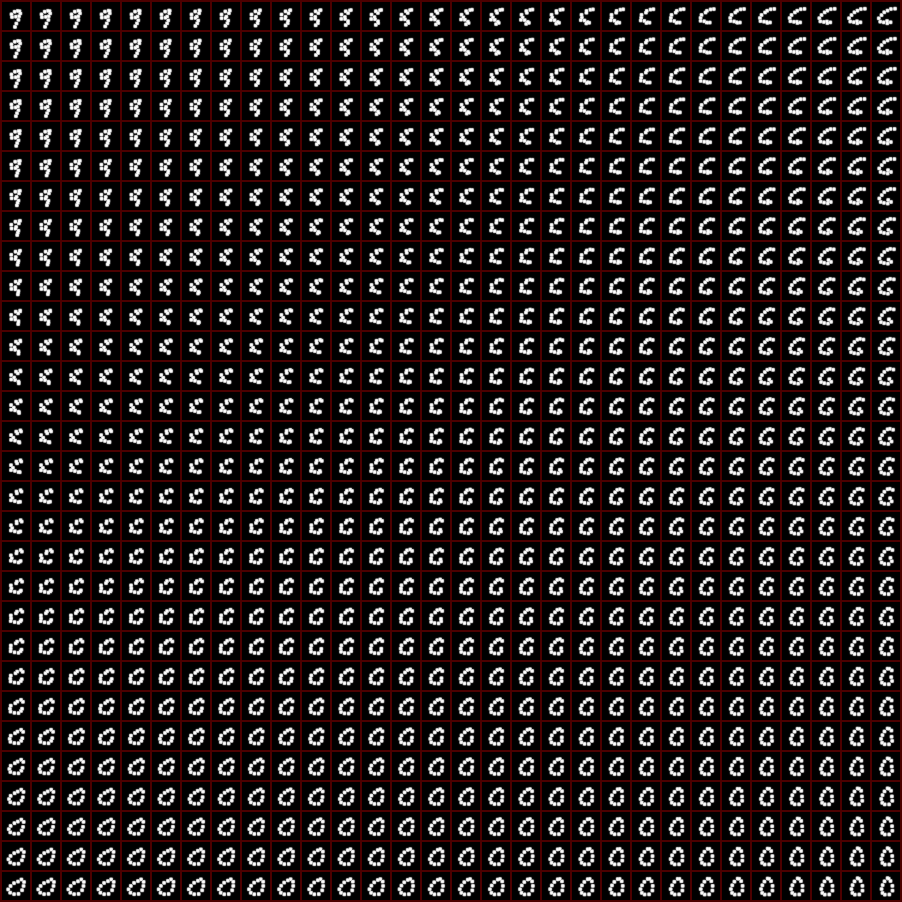

In [63]:
imsave('imgs/grid.png', disp_grid(grid_imgs, border=2, bordercolor=(0.3,0.,0.)), normalize=False)
Image('imgs/grid.png', width=500, height=500)